In [11]:
%matplotlib inline
import numpy as np
import pandas

import nsfg
import thinkstats2
import thinkplot

import survival
import chap01soln

**Survival Curve**, S(t) maps from a duration, t, to the probability of surviving longer than t.  

$$
S(t) =  1-\text{CDF}(t)
$$
where CDF(t) is the probability of a lifetime less than or equal to t

In [2]:
preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

nsfg.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.birthwgt_lb[df.birthwgt_lb > 20] = np.nan


In [3]:
##note: property is a method that can be invoked as if
##it were a variable.
class SurvivalFunction(object):
    
    def __init__(self, cdf, label=''):
        self.cdf = cdf
        self.label = label or cdf.label
        
    @property
    def ts(self):
        """
        sequence of lifetimes
        """
        return self.cdf.xs
    
    @property
    def ss(self):
        """
        survival curve
        """
        return 1 - self.cdf.ps
    
    def __getitem__(self, t):
        return self.Prob(t)
    
    def Prob(self, t):
        return 1 - self.cdf.Prob(t)

In [4]:
sf = survival.SurvivalFunction(cdf)
##fraction of pregs that proceed past the first trimester.
sf[13]


0.86021985878988294

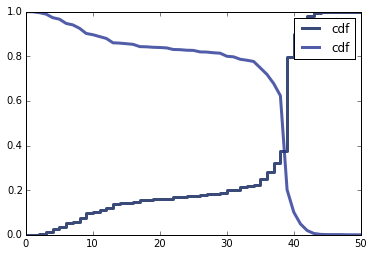

In [7]:
thinkplot.Plot(cdf)
thinkplot.Plot(sf)
thinkplot.Show()

**Hazard Function** - maps from a time, t, to the fraction of pregnancies that continue until t and then end at t.  Numerator is equal to PMF(t)

$$
\lambda(t) = \frac{S(t)-S(t+1)}{S(t)}
$$

In [8]:
hf = sf.MakeHazard()
##of all pregnancies that proceed until week 39, hf[39] end 
##in week 39
hf[39]

0.49689440993788797

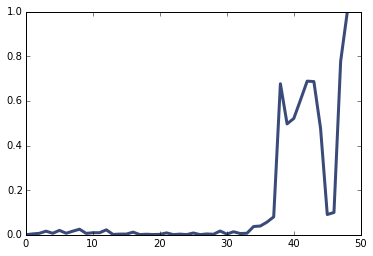

In [9]:
thinkplot.Plot(hf)

The goal of this chapter is to use NSFG data to quantify how long respondents "survive" until they get married for the first time.  The range of respondents is 14 to 44 years.  For women who have been married, the date of the first marriage is known.  For women not married, all we know is their age at the time of interview.

**Kaplan-Meier estimation** - we can use the data to estimate the hazard function then convert the hazard function to a survival curve.  For each age we consider:
1. the number of women who got married at that age
2. the number of women 'at risk' of getting married, which includes women who were not married at an earlier age.

In [13]:
def EstimateHazardFunction(complete, ongoing, label=''):
    """
    complete: set of complete observations (marriage age)
    ongoing: set of incomplete observations (age of resp)
    """
    n = len(complete)
    hist_complete = thinkstats2.Hist(complete)
    sf_complete = SurvivalFunction(thinkstats2.Cdf(complete))
    
    m = len(ongoing)
    sf_ongoing = SurvivalFunction(thinkstats2.Cdf(ongoing))
    
    lams = {}
    ##at_risk measures number of resps whose outcomes are not known at t
    ##ended = number of respondents married at age t
    ##n * sf_complete[t], num respondents married after age t
    ##m * sf_ongoing[t], num of unmarried resps inverviewed after t
    for t, ended in sorted(hist_complete.Items()):
        at_risk = ended + n * sf_complete[t] + m * sf_ongoing[t]
        lams[t] = ended /  at_risk
    
    return survival.HazardFunction(lams, label=label)

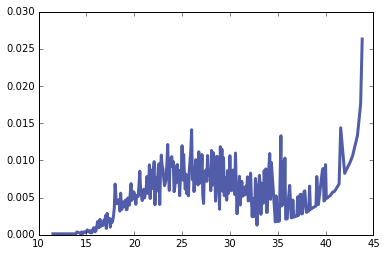

In [14]:
resp = chap01soln.ReadFemResp()
resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

complete = resp[resp.evrmarry==1].agemarry
ongoing = resp[resp.evrmarry==0].age

hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)

####Estimating the survival curve:
the chance of surviving past time t is the chance of surviving all times up throught, which is cumulative product of the complementary hazard function:
$$
[1-\lambda(0)][1-\lambda(1)]...[1-\lambda(t)]
$$


In [15]:
# HazardFunction:

def MakeSurvival(self):
    """
    ts: sequence of times where hazard function is estimated
    ss: cumulative product of comp hazard function
    """
    ts =  self.series.index
    ss = (1 -  self.series).cumprod()
    cdf = thinkstats2.Cdf(ts, 1 - ss)
    sf = SurvivalFunction(cdf)
    return sf
    

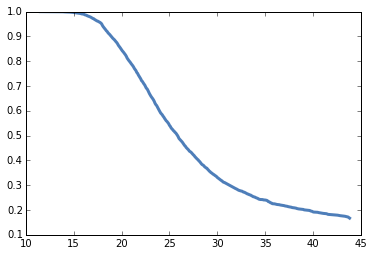

In [16]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)

In [25]:
##Sampling Error:
def ResampleSurvival(resp, iters=101):
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)
    ss_seq = []
    for i in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        hf, sf = survival.EstimateSurvival(sample)
        ss_seq.append(sf.Probs(ts))
    
    low, high = thinkstats2.PercentileRows(ss_seq, [5,95])
    thinkplot.FillBetween(ts, low, high)
        

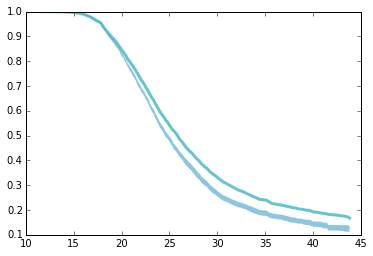

In [26]:
sf = hf.MakeSurvival()
ResampleSurvival(resp)
thinkplot.Plot(sf)
##discrepancy indicates that sample weights 
##have a substantial effect

####Cohort Effects

left part of the graph has data for all respondents, but right part of the graph only has the oldest respondents.  If the relevant characterisitics of respondents are not changing over time, that's fine, but in this case there are probably generational shifts.

We can investigate effect by grouping respondents according to their decade of birth.  These groups are called **cohorts**

In [31]:
month0 = pandas.to_datetime('1899-12-15')
dates = [month0 + pandas.DateOffset(months=cm)
         for cm in resp.cmbirth]
resp['decade'] = (pandas.DatetimeIndex(dates).year - 1900) // 10


In [35]:
def EstimateSurvivalByDecade(groups):
    for name, group, in groups:
        hf, sf = survival.EstimateSurvival(group)
        thinkplot.Plot(sf)

for i in range(1):
    samples = [thinkstats2.ResampleRowsWeighted(resp)
               for resp in resps]
    sample = pandas.concat(samples, ignore_index=True)
    groups = sample.groupby('decade')
    EstimateSurvivalByDecade(groups)
    

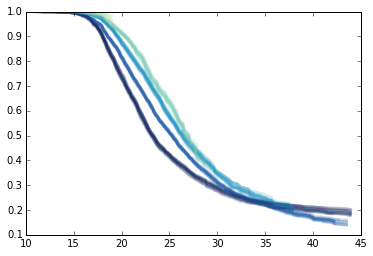

In [36]:
survival.PlotResampledByDecade(resps)

To extrapolate, we can "borrow" data from a pervious cohort...

In [37]:
# class HazardFunction

    def Extend(self, other):
        last = self.series.index[-1]
        more = other.series[other.series.index > last]
        serlf.series = pandas.concat([self.series, more])

IndentationError: unexpected indent (<ipython-input-37-12b2be828c0b>, line 3)

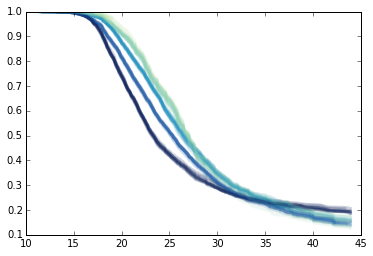

In [38]:
survival.PlotResampledByDecade(resps, predict_flag=True)

To plot expected remaining lifetime, we make a pmf from the survival function and then for each value of t, we cut off previous values and get the mean of the remaining values in the PMF.

**memoryless** - when the remaining lifetime function levels out completely, so past has no effect on the previous predictions.  "Any day now."  If you're still in the game now, anything can happen.

**NBUE** - "New better than used in expectation."  Young women have decreasing remaining "lifetimes."  New parts expected to last longer

**UBNE** - "Used better than new in expectaton"  The older the part, the longer it is expected to last.  Also newborns and cancer patients.

##Exercise
cmdivorcx - date of divorce for first marriage

Compute dur of marriages that ended in divorce and duration of ongoing marriages.  Estim haz and surv for duration of marriage

Use resampling to take inot account weights

Consider dividing into decades of birth and age at first marriage

In [39]:
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

In [120]:


def EstimateDivorceSS(resp, cleanData=False):
    if cleanData:
        resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
        resp.cmdivorcx.replace([9998,9999], np.nan, inplace=True)

        resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
        resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0
        resp['durmarr'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
        resp['sincemarr'] = (resp.age -  resp.agemarry)
    
    complete = resp[resp.durmarr.notnull()].durmarr
    ongoing = resp[resp.durmarr.isnull()][resp.evrmarry==1].sincemarr

    hf = EstimateHazardFunction(complete, ongoing)
    ss = hf.MakeSurvival()
    
    return hf, ss

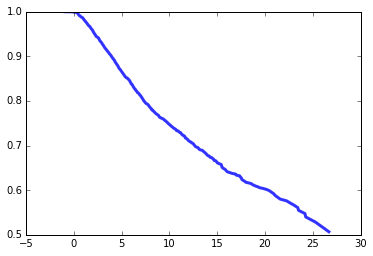

In [121]:
resp = chap01soln.ReadFemResp()
hf, ss = EstimateDivorceSS(resp, cleanData=True)
thinkplot.Plot(ss)

high 30.0833333333


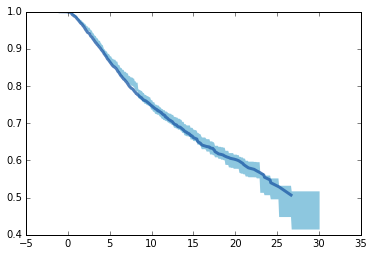

In [125]:
def PlotConfidenceIntervalSS(resp, iters=101, func=EstimateDivorceSS):
    low = 0
    high = resp[resp.durmarr.isnull()].sincemarr.max()
    print 'high',high
    ts = np.arange(low, high, 1/12.0)
    ss_seq = []
    for i in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        sample = sample.reset_index()
        hf, sf = func(sample)
        ss_seq.append(sf.Probs(ts))
    
    low, high = thinkstats2.PercentileRows(ss_seq, [5,95])
    thinkplot.FillBetween(ts, low, high)

thinkplot.Plot(ss)
PlotConfidenceIntervalSS(resp)

In [126]:
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

In [147]:
def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateDivorceSS(group, cleanData=True)
        thinkplot.Plot(sf, **options)

def PlotPredictionsByDecade(groups, **options):
    hfs = []
    for _, group in groups:
        hf, sf = EstimateDivorceSS(group, cleanData=True)
        hfs.append(hf)
    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

def PlotResampledDivorceByDecade(resps, iters=11, predict_flag=False, omit=None):
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp)
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        
        if omit:
            groups = [(name, group) for name, group in groups
                      if name not in omit]
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)
            
        if predict_flag:
            EstimateSurvivalByDecade(groups, alpha=0.2)
            try:
                PlotPredictionsByDecade(groups, alpha=0.2)
            except IndexError:
                pass
        else:
            print "not predicting"
            EstimateSurvivalByDecade(groups, alpha=0.2)

/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documenta

not predicting
not predicting
not predicting
not predicting
not predicting
not predicting
not predicting
not predicting
not predicting
not predicting
not predicting


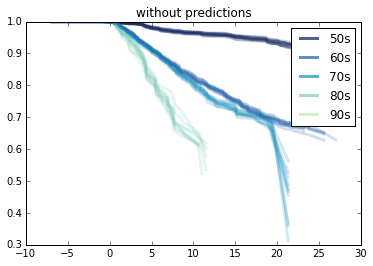

In [148]:
thinkplot.Config(title="without predictions")
PlotResampledDivorceByDecade(resps, predict_flag=False)
thinkplot.Show()

/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documenta

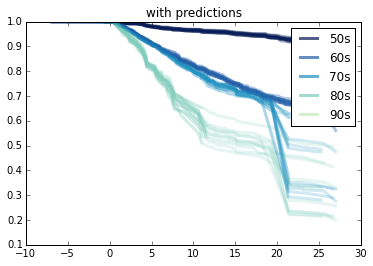

In [144]:
thinkplot.Config(title='with predictions')
PlotResampledDivorceByDecade(resps, predict_flag=True)
thinkplot.Show()

In [160]:
def CleanData2(resps):
    for r in resps:
        r['marrgroup'] = r.agemarry // 5
    
    

In [167]:
def marr_AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d' % ((name + 1) * 5)
        thinkplot.Plot([15], [1], label=label, **options)
def Marr_PlotResampledDivorceByDecade(resps, iters=11, predict_flag=False, omit=None):
    CleanData2(resps)
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp)
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        groups = sample.groupby('marrgroup')
        
        if omit:
            groups = [(name, group) for name, group in groups
                      if name not in omit]
        if i == 0:
            marr_AddLabelsByDecade(groups, alpha=0.7)
            
        if predict_flag:
            EstimateSurvivalByDecade(groups, alpha=0.2)
            try:
                PlotPredictionsByDecade(groups, alpha=0.2)
            except IndexError:
                pass
        else:
            EstimateSurvivalByDecade(groups, alpha=0.2)

/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documenta

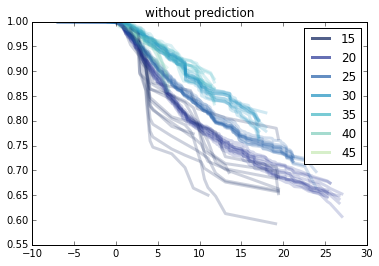

In [169]:
Marr_PlotResampledDivorceByDecade(resps)
thinkplot.Config(title="without prediction")
thinkplot.Show()

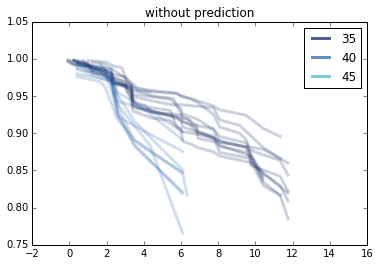

In [171]:
Marr_PlotResampledDivorceByDecade([resp7], omit=[0,1,2,3,4,5])
thinkplot.Config(title="without prediction")
thinkplot.Show()

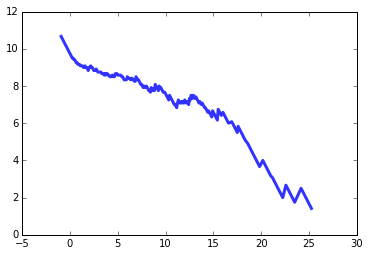

In [189]:
hf, sf = EstimateDivorceSS(resp, cleanData=True)

func = lambda pmf: pmf.Percentile(50)
rem_life = sf.RemainingLifetime(func=func)
thinkplot.Plot(rem_life)

Note that this whole study suffers from the assumption that all people who are currently married will get divorced.  I might have been better off using the total duration of the marriage for everybody without assuming there will be a divorce.